<span STYLE="font-size:150%"> 
    Plot drug release parameters
</span>

Docker image: gnasello/datascience-env:2023-01-27 \
Latest update: 20 March 2023

# Install packages

In [1]:
# Install from CRAN
install.packages("investr", dep = TRUE)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



# Load libraries

In [2]:
library(reshape2)
library(stringr)
library(ggplot2)
library(dplyr)
library(investr)
library(ggpubr)
library(latex2exp)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




How to Reuse Functions That You Create In Scripts, [tutorial](https://www.earthdatascience.org/courses/earth-analytics/multispectral-remote-sensing-data/source-function-in-R/)

In [3]:
source("r_utils/ggplot_utils.R")
source("r_utils/stats_utils.R")

In [6]:
filename <-  "2023-03-28_GN011_data.csv"
drugname <- 'AS2863619'

In [11]:
# Import the data and look at the first six rows
df <- read.csv(file = filename)
head(df)

,group,sample,release,day,Laponite,cum_sum
,<chr>,<int>,<dbl>,<int>,<int>,<dbl>
1,4-AS,1,14.187940,0,0,14.187940
2,4-AS,2,38.291608,0,0,38.291608
3,4-AS,3,12.406580,0,0,12.406580
4,4-AS,4,10.598519,0,0,10.598519
5,4-AS-L,1,19.968777,0,1,19.968777
6,4-AS-L,2,9.961502,0,1,9.961502


## Drop samples 4-8-12

These samples were removed becauase they were smaller than all the others.

[Remove Row by Multiple Condition](https://www.geeksforgeeks.org/how-to-conditionally-remove-rows-in-r-dataframe/)

In [12]:
df <- subset(df, df$sample != 4)
head(df)

,group,sample,release,day,Laponite,cum_sum
,<chr>,<int>,<dbl>,<int>,<int>,<dbl>
1,4-AS,1,14.187940,0,0,14.187940
2,4-AS,2,38.291608,0,0,38.291608
3,4-AS,3,12.406580,0,0,12.406580
5,4-AS-L,1,19.968777,0,1,19.968777
6,4-AS-L,2,9.961502,0,1,9.961502
7,4-AS-L,3,11.847760,0,1,11.847760


## Drop samples 4-AS-L

In [13]:
df <- subset(df, df$group != '4-AS-L' )
head(df)

,group,sample,release,day,Laponite,cum_sum
,<chr>,<int>,<dbl>,<int>,<int>,<dbl>
1,4-AS,1,14.18794,0,0,14.18794
2,4-AS,2,38.29161,0,0,38.29161
3,4-AS,3,12.40658,0,0,12.40658
9,6-AS,1,11.18976,0,0,11.18976
10,6-AS,2,20.51615,0,0,20.51615
11,6-AS,3,11.34043,0,0,11.34043


## Summarize the data

The function below will be used to calculate the mean and the standard deviation, for the variable of interest, in each group. See [tutorial](http://www.sthda.com/english/wiki/ggplot2-line-plot-quick-start-guide-r-software-and-data-visualization#line-graph-with-error-bars)

In [14]:
df1 <- data_summary(df, varname="cum_sum", 
                    groupnames=c("group", "day", "Laponite"))
df1

Loading required package: plyr

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize




group,day,Laponite,cum_sum,sd
<chr>,<int>,<int>,<dbl>,<dbl>
4-AS,0,0,21.62871,14.457955
4-AS,1,0,33.89572,12.926393
4-AS,2,0,46.13649,12.041680
4-AS,3,0,56.68480,13.599020
4-AS,5,0,74.58619,13.660186
6-AS,0,0,14.34878,5.341631
6-AS,1,0,26.29017,5.918039
6-AS,2,0,39.51944,2.290586
6-AS,3,0,55.09377,4.577327


# Plot release kinetics curve

Line plots

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


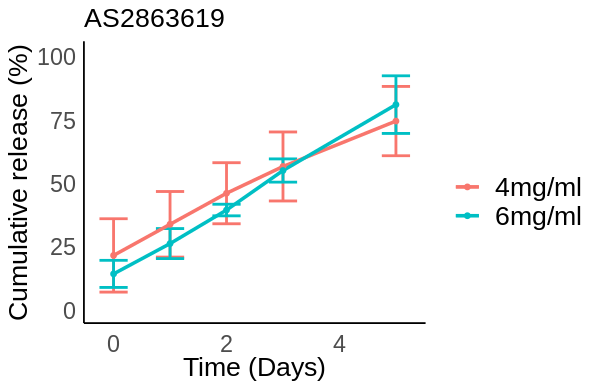

In [29]:
p <- ggplot(df1, aes(x=day, y=cum_sum, group=group, color=group)) + 
            geom_errorbar(aes(ymin=cum_sum-sd, ymax=cum_sum+sd), width=.5, size=0.8) +
            geom_line(size=1) + geom_point(size=1.25)

img <- ggplotMinAethetics(p, width=5, height=3.25,
                          title=drugname,
                          xlabel='Time (Days)', 
                          ylabel='Cumulative release (%)', 
                          scale_color='npg') + ylim(0, 101)+ 
        scale_color_discrete(labels=c('4mg/ml', '6mg/ml'), name = '')
img

# Get drug release parameters

## Logarithmic regression

Linear Regression and group by in R, [stackoverflow](https://stackoverflow.com/questions/1169539/linear-regression-and-group-by-in-r)

[`plotFit`](https://www.rdocumentation.org/packages/investr/versions/1.4.2/topics/plotFit): Plotting fitted models

[1] "4-AS"


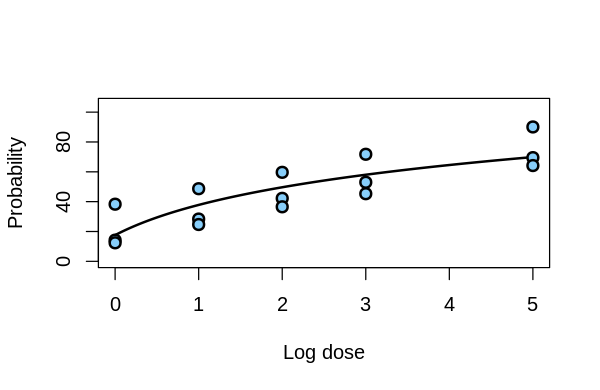

[1] "6-AS"


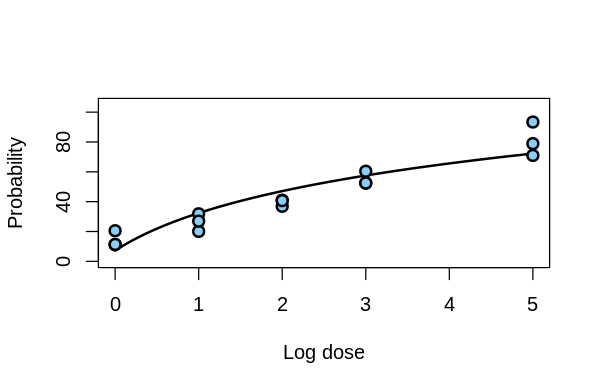

In [16]:
group_regress <- function(data){
       
    model = lm(cum_sum~log(day+1), data=data)
    
    plotFit(model, data = data,
            lwd.fit = 2, cex = 1.2, pch = 21, bg = "lightskyblue", 
            lwd = 2, xlab = "Log dose", ylab = "Probability",
            ylim=c(0,105), xlim=c(0,5)
           )
    
    print(data$group[1])
    
    model
    
    }

#fit log model
fitted_models <- df %>% 
                    group_by(group) %>% 
                        do( model = group_regress(data=.))

## Burst release

It is determined by the drug release fraction at 24 hours

In [17]:
k_df <- data.frame(matrix(ncol = 3, nrow = 0))

for(i in 1:nrow(fitted_models)) {       # for-loop over rows
    
    k <- predict(fitted_models$model[[i]], data.frame(day = 1), interval = "confidence")
    
    k_df <- rbind(k_df, k)

}

rownames(k_df) <- NULL
k_df['group'] <- fitted_models['group']

k_df

fit,lwr,upr,group
<dbl>,<dbl>,<dbl>,<chr>
37.80462,30.11839,45.49085,4-AS
32.34202,26.56273,38.12130,6-AS


Plot burst release parameter

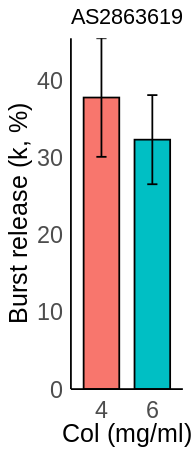

In [18]:
p <- ggbarplot(k_df, x = "group", y = "fit", fill = "group") + 
            geom_errorbar(aes(ymin=lwr, ymax=upr), width=.2, size=0.5)

ggplotMinAethetics(p, width=1.6, height=3.8,
                   title=drugname,
                   plot.title=element_text(size = 13),
                   xlabel='Col (mg/ml)', 
                   ylabel='Burst release (k, %)', 
                   scale_color='npg',
                   legend.position="none"
                  ) + theme(axis.title=element_text(size=15)) +
scale_x_discrete(labels=c("4-AS" = "4", "6-AS" = "6"))

## Half-life (t1/2)

It is determined by the time when the fraction of released drug reaches 50%

In [19]:
cond <- fitted_models$group[2]

invest(fitted_models$model[[2]], y0 = 50, x0.name='time', 
       mean.response = TRUE,
       lower=0.01, upper=20, # lower and upper are estimates based on your data 
       data=df[df$group==cond,]) 

estimate    lower    upper 
2.252457 1.818466 2.834064 

In [20]:
cond <- fitted_models$group[1]

invest(fitted_models$model[[1]], y0 = 50, x0.name='time',
       mean.response = TRUE,
       lower=0, upper=1000, # lower and upper are estimates based on your data 
       data=df[df$group==cond,]) 

estimate    lower    upper 
2.037069 1.386237 3.026491 

In [21]:
thalf_df <- data.frame(matrix(ncol = 3, nrow = 0))

for(i in 1:nrow(fitted_models)) {       # for-loop over rows
    
    t <- predict(fitted_models$model[[i]], data.frame(day = 1), interval = "confidence")
    cond <- fitted_models$group[i]
       
    t <- invest(fitted_models$model[[i]], y0 = 50, x0.name='time', 
                mean.response = TRUE,
                lower=0.1, upper=1000, # lower and upper are estimates based on your data 
                data=df[df$group==cond,]) 
    
    thalf_df <- rbind(thalf_df, t)

}

rownames(thalf_df) <- NULL
thalf_df['group'] <- fitted_models['group']

thalf_df <- subset(thalf_df, select = -c(interval) )
thalf_df

,estimate,lower,upper,group
,<dbl>,<dbl>,<dbl>,<chr>
1,2.037069,1.386236,3.026491,4-AS
2,2.252450,1.818465,2.834063,6-AS


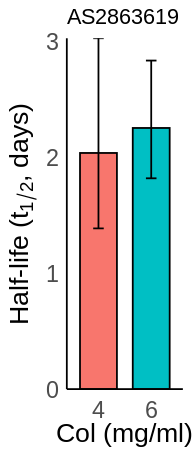

In [22]:
p <- ggbarplot(thalf_df, x = "group", y = "estimate", fill = "group") + 
               geom_errorbar(aes(ymin=lower, ymax=upper), width=.2, size=0.5)

ggplotMinAethetics(p, width=1.6, height=3.8,
                   title='AS2863619',
                   plot.title=element_text(size = 13),
                   xlabel='Col (mg/ml)',  
                   ylabel=TeX('Half-life (t$_{1/2}$, days)'), 
                   scale_color='npg',
                   legend.position="none"
                  ) + 
scale_x_discrete(labels=c("4-AS" = "4", "6-AS" = "6"))

## Save release parameters

In [23]:
colnames(k_df) <- colnames(thalf_df)

In [24]:
k_df

estimate,lower,upper,group
<dbl>,<dbl>,<dbl>,<chr>
37.80462,30.11839,45.49085,4-AS
32.34202,26.56273,38.12130,6-AS


In [25]:
write.csv(k_df, "burst_release_collagen.csv", row.names=FALSE)

In [26]:
thalf_df

,estimate,lower,upper,group
,<dbl>,<dbl>,<dbl>,<chr>
1,2.037069,1.386236,3.026491,4-AS
2,2.252450,1.818465,2.834063,6-AS


In [27]:
write.csv(thalf_df, "half_life_collagen.csv", row.names=FALSE)